
# Multilayer Perceptron

In [1]:
from math import exp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def load_dataset(filename: str) -> pd.DataFrame:
    '''Load and return the content of `filename` into a Pandas DataFrame'''
    
    
    return pd.read_csv(filename, delim_whitespace=True)

In [3]:
def split_dataset(dataset: pd.DataFrame) -> (list, list, list, list):
    '''Split the `dataset` into 4 lists: 2 for training and 2 to test the prediction'''
    
    
    labels_train = dataset.values[:,-1]
    training_samples = dataset.values[:,:-1]

    theta = np.ones((labels_train.size, 1))
    training_samples = np.concatenate((training_samples, theta), axis=1)
    
    return training_samples, training_samples[:], labels_train, labels_train[:]

In [4]:
class MLP(object):
    '''Implements a Multilayer Percemptron (MLP) Artificial Neural Network (ANN)'''


    def __init__(self: object, *, input_layer: int, hidden: int, output: int):
        self.error = np.inf
        self.errors = []

        self.layers = {}
        self.layers['hidden'] = self.create_layer(hidden, input_layer + 1)
        self.layers['output'] = self.create_layer(output, hidden + 1)
        
        self.hidden_shape = (hidden, input_layer + 1)
        self.output_shape = (output, hidden + 1)


    def create_layer(self: object, rows: int, columns: int) -> np.array:
        #np.random.random -> [0.0, 1.0) with - .5 --> [-0.5, 0.5)
        return np.random.random(rows * columns).reshape(rows, columns) - .5


    def forward(self: object, pattern: list) -> dict:
        forward_values = {}
        
        self.config_forward('hidden', pattern, ['hidden', 'hidden_df'], forward_values)
        
        pattern = np.concatenate((forward_values['hidden'], [1.]), axis=0)
        self.config_forward('output', pattern, ['output', 'output_df'], forward_values)
            
        return forward_values

    
    def apply_forward(self: object, keys: list, forward_values: dict, nets: np.array) -> dict:
        for key in keys:
            func = self.df_dnet if key.endswith('_df') else self.neuron_output
            forward_values[key] = func(nets) if nets.size == 1 else [func(net) for net in nets]
        return forward_values
    
    
    def config_forward(self: object, layer_name: str, pattern: list, 
                       keys: list, forward_values: 
                       dict) -> dict:
            layer = self.layers[layer_name]
            nets = layer.dot(pattern)
            return self.apply_forward(keys, forward_values, nets)

        
    def fit(self: object, training_samples: list, labels_train: list,
            learning_rate=.1, max_iterations=int(1e4), error=1e-2) -> None:
        '''
        Perform Backpropagation algorithm until the cost function produces a
        square error lesser than the (optional) given param `error`. Or until
        hit the (optional) given param `max_iterations`
        '''

        
        for age in range(2 ** 32):
            squared_error = 0
            
            for pattern, label in zip(training_samples, labels_train):
                fwd = self.forward(pattern)
                obtained = fwd['output']
                
                delta_pattern = label - obtained
                squared_error += np.sum(delta_pattern ** 2)
                
                delta_output = delta_pattern * fwd['output_df']
                delta_hidden = fwd['hidden_df'] * (np.dot(delta_output, self.layers['output'][0][:-1]))
                
                self.layers['output'] += learning_rate * (np.dot(delta_output, fwd['hidden'] + [1.]))
                self.layers['hidden'] += learning_rate * (
                    np.dot(np.matrix(delta_hidden).transpose(), np.matrix(pattern)))
                
            squared_error /= len(training_samples)
            self.errors.append(squared_error)
            self.error = squared_error
                    
            if squared_error < error:
                break


    def predict(self: object, test_samples: list) -> list:
        '''
        Make a prediction to the given param `test_samples`
        '''

        
        return [self.forward(sample)['output'] for sample in test_samples]


    def df_dnet(self: object, net: int) -> float:
        '''Returns f(net) * (1 - f(net))'''

        return self.neuron_output(net) * (1 - self.neuron_output(net))


    def neuron_output(self: object, net: int) -> float:
        '''
        '''
        return 1 / (1 + exp(-net))

    
    def __str__(self: object) -> None:
        format_str = "Hidden weights\n{}\nOutput weights\n{}"
        return format_str.format(self.layers['hidden'], self.layers['output'])


    def plot_errors(self: object) -> None:
        '''
        Generate a plot with the error curve obtained during the last training
        of the MLP
        '''


        plt.xlabel("$Iterations$")
        plt.ylabel("$Error - (MSE)$")
        plt.plot(
            self.errors, "b{}-".format("o" if len(self.errors) < 25 else ""),
            label="Mean Square Error (MSE) in the first {} iterations".
            format(len(self.errors))
        )
        plt.legend(loc="upper right")
        plt.axis([-.1, len(self.errors), -.1, max(self.errors) + .5])
        plt.grid(True)
        plt.show()

## First Example, the ```Xor``` case

#### Display the Dataset

In [5]:
dataset = load_dataset("xor.dat")
dataset.head()

,X,Y,Output
0,0,0,0
1,0,1,1
2,1,0,1
3,1,1,0


#### Plot of the Dataset

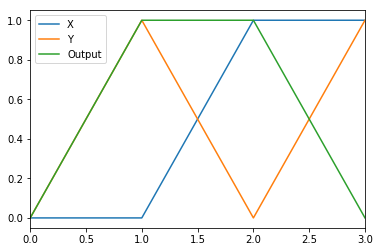

In [6]:
dataset.plot();

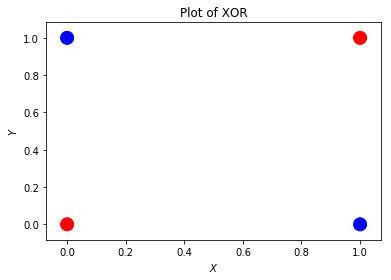

In [7]:
training_samples, testing_samples, labels_train, labels_test = split_dataset(dataset)

colors = ["red" if label == 0 else "blue" for label in labels_train]

plt.figure()
plt.scatter(training_samples[:, 0], training_samples[:, 1], s=170, color=colors)

plt.xlabel("$X$")
plt.ylabel("$Y$")
plt.title("Plot of XOR")

plt.show()

In [8]:
clf = MLP(input_layer=2, hidden=2, output=1)
clf.fit(training_samples, labels_train)

In [9]:
pred = clf.predict(testing_samples)
print('Convergence: with MSE:{}'.format(clf.error))

Convergence: with MSE:0.009999075932332088


In [10]:
print(clf)

Hidden weights
[[ 3.33654087  3.33443798 -5.15946598]
 [-5.32783051 -5.32921878  1.75698222]]
Output weights
[[-6.52523112 -6.61128375  3.24450323]]


In [11]:
pd.DataFrame.from_items([('Expected', labels_test), ('Obtained', pred)])

,Expected,Obtained
0,0,0.080833
1,1,0.896408
2,1,0.896233
3,0,0.108861


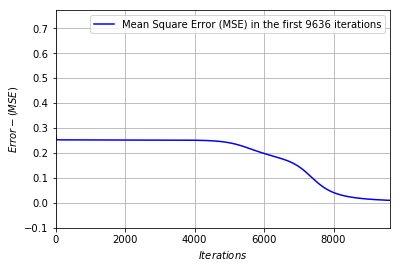

In [12]:
clf.plot_errors()

-------------------------------

#### :wq